# COGS 108 - Final Project 

# Overview

In this project, I explored the relationship between the crime rate in the surrounding area of a park or recreational area in San Diego and the Yelp review (1-5 stars) it received. I used the Priority E and Priority 1 police responses as a proxy to approximate the crime rate in that area. My analysis found no statistically significant correlationg between the dependent and independent variables and conclude that San Diego parks located in areas with lower crime rate do not necessarily receive better reviews on Yelp. 

# Name & GitHub

- Name: Qixuan "Harrison" Ma
- GitHub Username: Harrison-Q-Ma

# Research Question

Does the crime rate in the surrounding area affect the yelp review for a certain park or recreational area in the San Diego area?

## Background and Prior Work

A lot of previous work link the availability of parks in the city to the overall crime rate of the city. Studies have found a correlation between the amount of green space in the city to the rate of violent crimes in the city: the more green space, the lower the violent crime rate. CDC also found a correlation between people's behavior in park usage and the types of crimes being committed in the city. However, these studies did not explore the question in more detail. Therefore, in this project, I want to do some more in depth about the effect on parks on the crime rate of its immediate surrounding areas. 

References:
- 1) Effects of Crime Type and Location on Park Use Behavior (CDC) https://www.cdc.gov/pcd/issues/2020/19_0434.htm
- 2) The Impact of Green Space on Violent Crime in Urban Environments: An Evidence Synthesis https://www.mdpi.com/journal/ijerph
- 3) Safe cities: California, Texas are home to many of towns with lower violent crime rates https://www.usatoday.com/story/money/2019/10/27/crime-rates-lower-in-these-us-safest-cities/40406533/
- 4) Can Parks Help Cities Fight Crime? https://theconversation.com/can-parks-help-cities-fight-crime-118322#:~:text=One%202015%20study%20of%20multiple,up%20to%2011%20times%20worse.

# Hypothesis


My hypothesis for this is that parks and recreational areas located in the parts of the city with the least crime rates would receive better reviews on Yelp. 

# Dataset(s)

Dataset 1: 
- Dataset Name: Yelp Data for San Diego Parks (yelp_SD_parks.csv)
- Link to the dataset: https://www.yelp.com/
- Number of observations: 834
- Description: 
    Dataset 1 contains a list of locations in the San Diego area that is commonly recognized as parks and recreational areas. I will be conduct all further analysis based on the review scores on this list.
    
Dataset 2: 
- Dataset Name: Crime Rate in San Diego (pd_calls_for_service_2019.csv)
- Link to the dataset: https://data.sandiego.gov/datasets/police-calls-for-service/
- Number of observations: 590968
- Description: This dataset contains the specific location for each of the calls that the police department received for the year of 2019. I will not be using any data from 2020 due to the year not being over yet and the calls are probably screwed towards focusing more on residential areas due to stay-at-home orders. 


I will be using Dataset 2 (locations) to calculate a overall "score" of each park that comprises of its proximity to the crimes in the area. Then I will compare that score to the reviews these parks received on Yelp and see if they correlate at all. 

# Setup

In [1]:
# importing packages that I will be using
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
import requests
import math
from shapely.geometry import Point
import descartes
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
# reading the data files into pandas dataframes
df_sd_parks_review = pd.read_csv("yelp_SD_parks.csv") # Yelp review for SD parks
df_sd_pd_resp = pd.read_csv("pd_calls_for_service_2019_datasd.csv") # Police calls in the year of 2019

# Data Cleaning

First we deal with the reviews on Yelp. In the follow 2 cell blocks, I will drop the columns and rows that contain information that are not really needed for my analysis or contain outlying information that will skew the data. 

In [4]:
# I will first drop the columns of phone, id, opening status, and url as they are not related to my analysis
df_sd_parks_review = df_sd_parks_review.drop(columns = ['phone', 'id', 'url', 'is_closed'])

# I will then drop all observations with review counts that are less than 20, to make sure we don't have outliers due to 
# limited sample size
indexNum = df_sd_parks_review[df_sd_parks_review['review_count'] <= 20].index
df_sd_parks_review.drop(indexNum, inplace = True)



In [5]:
# drop rows with outliers
indexNum = df_sd_parks_review[df_sd_parks_review['longitude'] <= -117.5].index
df_sd_parks_review.drop(indexNum, inplace = True)

indexNum = df_sd_parks_review[df_sd_parks_review['longitude'] >= -110.0].index
df_sd_parks_review.drop(indexNum, inplace = True)

indexNum = df_sd_parks_review[df_sd_parks_review['latitude'] >= 34].index
df_sd_parks_review.drop(indexNum, inplace = True)

In the following cell, I will do the following: 
1. Add new column called address to add later
2. Drop columns that I don't need in the police report database
3. Because we are using police report as a proxy for crime rate, I want to focus only on the more significant instances, in other words, the higher priority calls. In the police report, Priority 0 ("E") calls refer to those that "involve an imminent threat to life" and Priority 1 calls refer to those that "involve serious crimes in progress and those in which there is a threat to life". I will drop all rows with lower priorities so we don't count a loud party in our calculation of crime rate. 
4. There are addresses listed in the police report that only contain partial information about the location, which makes it hard to determine the geolocation of it. This will also cause errors in the conversion to geocode, so I will drop these as well. 

In [6]:
# add new column called address to add later
df_sd_pd_resp = df_sd_pd_resp.assign(address = df_sd_pd_resp['incident_num'])

# drop columns that we don't need
df_sd_pd_resp = df_sd_pd_resp.drop(columns = ['incident_num', 'date_time', 'day_of_week', 'address_dir_intersecting', 'address_road_intersecting', 'address_sfx_intersecting', 'call_type', 'disposition', 'beat'])

# drop lower priority police calls
indexNum = df_sd_pd_resp[df_sd_pd_resp['priority'] > 1].index
df_sd_pd_resp.drop(indexNum, inplace = True)

# drop rows with not enough information to determine the location
indexNum = df_sd_pd_resp[df_sd_pd_resp['address_number_primary'] == 0].index
df_sd_pd_resp.drop(indexNum, inplace = True)

indexNum = df_sd_pd_resp[df_sd_pd_resp['address_sfx_primary'] != df_sd_pd_resp['address_sfx_primary']].index
df_sd_pd_resp.drop(indexNum, inplace = True)

In this cell, I performed some string manipulations to concatenate different columns in the police report and come up with a single string that has the information required to accurately describe the location of an address. 

In [7]:
# Perform string manipulation to get a single address from different columns in the police report

for ind in df_sd_pd_resp.index: #REMEMBER TO CHANGE LATER
    
    output=''
    
    # add the street number if it is not 0
    if df_sd_pd_resp['address_number_primary'][ind] == 0:
        pass
    else:
        output += str(df_sd_pd_resp['address_number_primary'][ind])
        output += ' '
    
    # add the street prefix (south, north, etc) if they are not NaN
    if df_sd_pd_resp['address_dir_primary'][ind] != df_sd_pd_resp['address_dir_primary'][ind]: 
        pass
    else: 
        output += str(df_sd_pd_resp['address_dir_primary'][ind])
        output += ' '
    
    # add the street name (e.g. Gilman) if they are not null
    if df_sd_pd_resp['address_road_primary'][ind] != df_sd_pd_resp['address_road_primary'][ind]: 
        pass
    else: 
        output += str(df_sd_pd_resp['address_road_primary'][ind])
        output += ' '
    
    # add the street subfix (e.g. Ave, St, Pl) if they are not null
    if df_sd_pd_resp['address_sfx_primary'][ind] != df_sd_pd_resp['address_sfx_primary'][ind]:
        pass
    else: 
        output += str(df_sd_pd_resp['address_sfx_primary'][ind])
    
    # add San Diego, US to avoid getting geolocations that are very far off
    output += ", San Diego, US"
        
    # setting the address column of the current row to be output
    df_sd_pd_resp.ix[ind, 'address'] = output

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [8]:
# Generate a new column in the police response to store the geocode that we will generate later
df_sd_pd_resp = df_sd_pd_resp.assign(geocode = df_sd_pd_resp['address'])

# due to the limitation of computing power, I do not have the resources to perform analysis on all observations (as I have 
# mentioned in a Piazza post)
df_sdpd_rand = df_sd_pd_resp.sample(n=8000)

In the following cell, I will first create two new columns to store latitude and longitude data (default being -1.0). Then I will use the Nominatim service to generate geocode data (latitude and longitude) from a string of address and store them back to the new columns I created. 

In [9]:
df_sdpd_rand = df_sdpd_rand.assign(latitude = -1.0)
df_sdpd_rand = df_sdpd_rand.assign(longitude = -1.0)

for ind in df_sdpd_rand.index:   
    geolocator = Nominatim(user_agent="COGS 108 Proj")
    location = geolocator.geocode(df_sdpd_rand.ix[ind, 'address'])
    
    if (hasattr(location, 'longitude') and hasattr(location, 'longitude')):    
        df_sdpd_rand['geocode'][ind] = location
        df_sdpd_rand['latitude'][ind] = location.latitude
        df_sdpd_rand['longitude'][ind] = location.longitude   
    else:    
        pass


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site

In the following cell, I drop the rows that are unable to generate a geocode that make sense or at all. 

In [10]:
# lastly, we drop the rows whose latitude or longitude is -1 (cant find address)
indexNum = df_sdpd_rand[df_sdpd_rand['latitude'] == -1].index
df_sdpd_rand.drop(indexNum, inplace = True)
indexNum = df_sdpd_rand[df_sdpd_rand['longitude'] == -1].index
df_sdpd_rand.drop(indexNum, inplace = True)
indexNum = df_sdpd_rand[df_sdpd_rand['longitude'] >= -117].index
df_sdpd_rand.drop(indexNum, inplace = True)

df_sdpd_rand.head()

,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,priority,address,geocode,latitude,longitude
50860,3900,NaN,BATEMAN,AVE,0,"3900 BATEMAN AVE, San Diego, US","(Bateman Avenue, Otay Mesa West, San Diego, Sa...",32.577412,-117.048828
214253,9400,NaN,AERO,DR,1,"9400 AERO DR, San Diego, US","(Aero Drive, San Diego, San Diego County, Cali...",32.809105,-117.117656
16074,10000,NaN,BORDELON,ST,1,"10000 BORDELON ST, San Diego, US","(Bordelon Street, San Diego, San Diego County,...",32.813721,-117.108231
298963,600,NaN,COCHRAN,AVE,1,"600 COCHRAN AVE, San Diego, US","(Cochran Avenue, San Diego, San Diego County, ...",32.585285,-117.058899
139084,3300,NaN,WICOPEE,PL,0,"3300 WICOPEE PL, San Diego, US","(Wicopee Place, San Diego, San Diego County, C...",32.816338,-117.211693


In the follow cell, I will plot the location of the Priority E and 1 crimes and parks in the San Diego area. 

Text(170.43749892811908, 0.5, 'latitude')

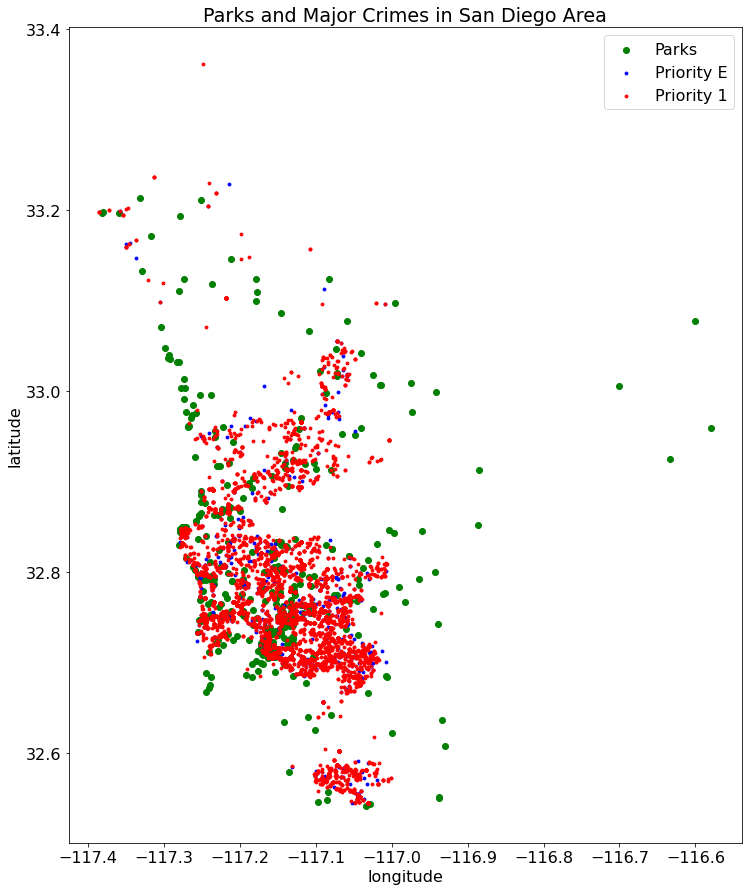

In [11]:
geometry = [Point(xy) for xy in zip(df_sdpd_rand['longitude'], df_sdpd_rand['latitude'])]
geometry2 = [Point(xy) for xy in zip(df_sd_parks_review['longitude'], df_sd_parks_review['latitude'])]
geometry[:3]
geometry2[:3]

crs = {'init' : 'epsg:4326'}

geo_df = gpd.GeoDataFrame(df_sdpd_rand, crs="EPSG:4326", geometry=geometry)
geo_df2 = gpd.GeoDataFrame(df_sd_parks_review, crs="EPSG:4326", geometry=geometry2)


fig, ax = plt.subplots(figsize = (15,15))
#sd_map.plot(ax = ax, alpha = 0.4, color="grey")
geo_df2.geometry.plot(marker='o', color = 'green', ax = ax, label = "Parks")
geo_df[geo_df['priority'] == 0].plot(ax=ax, markersize = 8, color = "blue", marker = "o", label = "Priority E")
geo_df[geo_df['priority'] == 1].plot(ax=ax, markersize = 8, color = "red", marker = "o", label = "Priority 1")
plt.title("Parks and Major Crimes in San Diego Area")
plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')

In the following 2 cells, I will generate crime rate scores for each of the parks using 3 methods. In the first one (score_1), I will calculate a score for each park as a sum of the product of its distance with each of the crime locations and the priority. In this way, lower score means higher crime rate. 

In [12]:
E_Rad = 6373.0
df_sd_parks_review = df_sd_parks_review.assign(score_1 = 0)

# Calculate score based on priority and all crimes
for ind1 in df_sd_parks_review.index:
    score = 0
    lat1 = math.radians(df_sd_parks_review['latitude'][ind1])
    lon1 = math.radians(df_sd_parks_review['longitude'][ind1])
    
    for ind2 in df_sdpd_rand.index:
        lat2 = math.radians(df_sdpd_rand['latitude'][ind2])
        lon2 = math.radians(df_sdpd_rand['longitude'][ind2])
        
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        score += E_Rad * c * df_sdpd_rand['priority'][ind2]
    
    df_sd_parks_review.ix[ind1, 'score_1'] = score
        
        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In the second one (score_2), I will calculate a score for each park as a sum of the product of its distance with each of the crim locations and the priority that are within 0.5 kilometers radius from the park. This should eliminate the effect of farther away crimes on the scores. We default the score to be -0.01 (impossible to result from calculations) and will drop those columns later in analysis. 

In [13]:
# Calculate score based on crimes within a 1km diameter circle
df_sd_parks_review = df_sd_parks_review.assign(score_2 = 0)
rad = 0.5
E_Rad = 6373.0

for ind1 in df_sd_parks_review.index:
    score = -0.01
    lat1 = math.radians(df_sd_parks_review['latitude'][ind1])
    lon1 = math.radians(df_sd_parks_review['longitude'][ind1])
    
    park_loc = Point(df_sd_parks_review['latitude'][ind1],df_sd_parks_review['longitude'][ind1])
    for ind2 in df_sdpd_rand.index:
        lat2 = math.radians(df_sdpd_rand['latitude'][ind2])
        lon2 = math.radians(df_sdpd_rand['longitude'][ind2])
        
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        
        a = math.sin(dlat / 2.0)**2.0 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2.0)**2.0
        c = 2.0 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = E_Rad * c
            
        if distance <= rad:
            score += distance * df_sdpd_rand['priority'][ind2]
        else: 
            pass
        
    df_sd_parks_review.ix[ind1, 'score_2'] = score

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In the third one (score_3), I will calculate a score for each park as a sum of the product of its distance with each of the crim locations and the priority that are within 0.5 kilometers radius from the park. This should eliminate the effect of farther away crimes on the scores. Unlike score_2, score_3 will be adjusted according to the distance squared (like GRAVITY!!!). We default the score to be -0.01 (impossible to result from calculations) and will drop those columns later in analysis.

In [14]:
# Calculate score based on crimes within a 1km diameter circle with priority decreasing as the square of the distance
df_sd_parks_review = df_sd_parks_review.assign(score_3 = 0)
rad = 0.5
E_Rad = 6373.0

for ind1 in df_sd_parks_review.index:
    score = -0.01
    lat1 = math.radians(df_sd_parks_review['latitude'][ind1])
    lon1 = math.radians(df_sd_parks_review['longitude'][ind1])
    
    park_loc = Point(df_sd_parks_review['latitude'][ind1],df_sd_parks_review['longitude'][ind1])
    for ind2 in df_sdpd_rand.index:
        lat2 = math.radians(df_sdpd_rand['latitude'][ind2])
        lon2 = math.radians(df_sdpd_rand['longitude'][ind2])
        
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        
        a = math.sin(dlat / 2.0)**2.0 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2.0)**2.0
        c = 2.0 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = E_Rad * c
            
        if distance <= rad:
            score += distance * distance * df_sdpd_rand['priority'][ind2]
        else: 
            pass
        
    df_sd_parks_review.ix[ind1, 'score_3'] = score

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In the following cell, I will make a separate dataframe which excluded the points that have no crime in the 0.5 km area around it so these do not skew our data. 

In [15]:
df_sd_parks_review_2 = df_sd_parks_review
indexNum = df_sd_parks_review_2[df_sd_parks_review_2['score_2'] == -0.01].index
df_sd_parks_review_2.drop(indexNum, inplace = True)
df_sd_parks_review_2

,name,address,rating,review_count,longitude,latitude,geometry,score_1,score_2,score_3
0,Balboa Park,"1549 El Prado San Diego, CA 92101",5.0,2105,-117.153150,32.734502,POINT (-117.15315 32.73450),61016.290384,0.413502,0.169354
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",4.5,46,-117.147278,32.778315,POINT (-117.14728 32.77831),60853.334927,5.363585,2.405990
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",4.5,242,-117.172479,32.721952,POINT (-117.17248 32.72195),66079.701093,2.137766,0.792201
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",4.5,102,-117.143789,32.762463,POINT (-117.14379 32.76246),59188.213435,0.490161,0.073387
5,Centrum Park,"8578 Lightwave Ave San Diego, CA 92123",3.5,22,-117.138397,32.828037,POINT (-117.13840 32.82804),73893.924112,2.352769,0.600311
...,...,...,...,...,...,...,...,...,...,...
818,The Cottage La Jolla,"7702 Fay Ave La Jolla, CA 92037",4.0,4211,-117.274957,32.843422,POINT (-117.27496 32.84342),107575.925516,15.039988,5.908432
819,Brockton Villa Restaurant,"1235 Coast Blvd La Jolla, CA 92037",4.0,1749,-117.271558,32.849777,POINT (-117.27156 32.84978),108224.952319,1.570587,0.376360
822,Capehart Dog Park,"4747 Soledad Mountain Rd San Diego, CA 92109",3.0,85,-117.225335,32.807007,POINT (-117.22533 32.80701),80255.086142,14.190472,4.088440
829,San Diego Metropolitan Transit System,"1255 Imperial Ave Ste 1000 San Diego, CA 92101",2.5,268,-117.153400,32.705760,POINT (-117.15340 32.70576),67869.559286,34.225871,14.166824


# Data Analysis & Results

Now we have an longitude and latitude for each police response and each parks. Now, I will calculated a score for each park from the priority of the police call and the distance from all police response calls (priority * distance). Parks with a lower combined score indicate that there is higher crime rate in their area. 

First, let's make a scatter plot of the rating of parks (x-axis) versus scores of the parks (y-axis). 

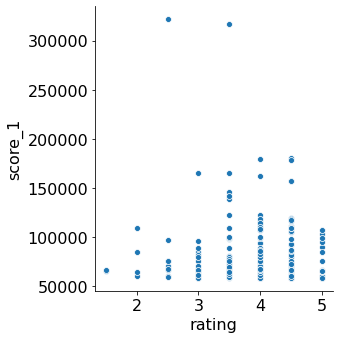

In [17]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
sns.relplot(x = 'rating', y = 'score_1', data = df_sd_parks_review)

Then, we perform a OSL Regression test on the dataset to find the correlation of the dataset.

In [18]:
outcome1, predictors1 = patsy.dmatrices('rating ~ score_1', df_sd_parks_review)

mod1 = sm.OLS(outcome1, predictors1)
## fit the model
res1 = mod1.fit()

## look at the results
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9568
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.329
Time:                        17:28:17   Log-Likelihood:                -282.06
No. Observations:                 280   AIC:                             568.1
Df Residuals:                     278   BIC:                             575.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0613      0.109     37.419      0.0

We can see that in this model, the crime rate around a park does not explain its review on Yelp very well, as it only has a 0.003 R-Squared value, meaning that only 0.1 percent of all variance in the dependent variable (Yelp review) can be explained by the independent variable (crime rate). 

Now, let's try plotting and analyzing the second model. 

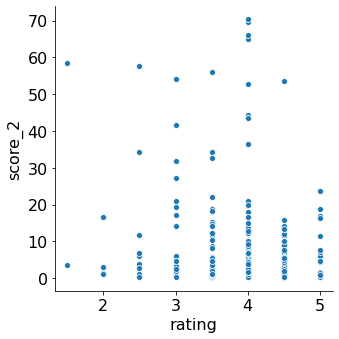

In [19]:
sns.relplot(x = 'rating', y = 'score_2', data = df_sd_parks_review_2)

The above scatterplot is the rating of the parks (x-axis) versus the crime rate in that area as modeled by the third model. Again, we see no clear trend in crime rate as the rating of parks get higher and that there are quite a few outliers with an extremely high score. 

In [20]:
outcome2, predictors2 = patsy.dmatrices('rating ~ score_2', df_sd_parks_review_2)

mod2 = sm.OLS(outcome2, predictors2)
## fit the model
res2 = mod2.fit()

## look at the results
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.400
Date:                Wed, 16 Dec 2020   Prob (F-statistic):            0.00405
Time:                        17:28:17   Log-Likelihood:                -278.38
No. Observations:                 280   AIC:                             560.8
Df Residuals:                     278   BIC:                             568.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0391      0.047     85.412      0.0

We can see that this model accounts for the correlation between crime rate and Yelp review much better because it has a much higher R-Squared value of 0.029, which means that 2.9 percent of all variance in the dependent variable (Yelp review) can be accounted for by the independent variable (crime rate). 

Now, let's move on to the third model. 

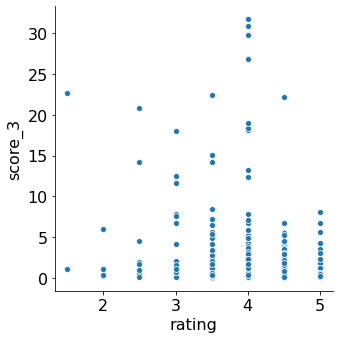

In [23]:
sns.relplot(x = 'rating', y = 'score_3', data = df_sd_parks_review_2)

The above scatterplot is the rating of the parks (x-axis) versus the crime rate in that area as modeled by the third model. Again, we see no clear trend in crime rate as the rating of parks get higher. 

In [26]:
outcome3, predictors3 = patsy.dmatrices('rating ~ score_3', df_sd_parks_review_2)

mod3 = sm.OLS(outcome3, predictors3)
## fit the model
res3 = mod3.fit()

## look at the results
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.308
Date:                Wed, 16 Dec 2020   Prob (F-statistic):            0.00729
Time:                        18:40:38   Log-Likelihood:                -278.91
No. Observations:                 280   AIC:                             561.8
Df Residuals:                     278   BIC:                             569.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0290      0.046     86.908      0.0

Surprisingly, this gives us a lower R-squared value than the second one. 

So, all in all, the best model I have generated is the second model. We have reached a p-value (P>|t|) of less than 0.05 for both the second and the third model, we can reject the null hypothesis that there is a relationship between crime rate around a park in San Diego area and its Yelp review in favor of the alternative hypothesis that there is no statistically significant relationship between crime rate in the surrounding area of the park in the San Diego area and its Yelp review. 

# Ethics & Privacy

Privacy is not a huge concern in this study since all the data are not personally identifiable. The exact locations of the addresses of the police department calls will not be directly related to my analysis and I will only distance from where these calls are placed to the parks. The data I received are collected from San Diego municiple and county government are authorized for all public and education uses. The police report contains little to no bias because it collects all police reponses regardless of where the location is or who the caller is. The Yelp review dataset is made by taking the average of all Yelp review scores, which will average out all potential biases and represent the population without excluding a certain group. I do not identify any way my analysis could lead to problems in terms of data privacy anmd equitable impact as my analysis concluded that there is no statistically significant relationship between the variables. This does not provide incentive for the municiple or county government to distribute park resources more in favor of areas with lower crime rates in order to be better received by the general public. 

# Conclusion & Discussion

I started the project with the question of whether there is a correlation between the crime rate in the park's surrounding area and how much the public like it. I decided to model public perception of the park by Yelp reviews that the park received and crime rate by the amount and priority of police reponses in its surrounding areas. I used two datasets, one containing each parks' review score and the other one containing all police reponses in the San Diego area in 2019. 

In my analysis, I proposed three models to approximate crime rate as a score for each of the parks and conducted a OLS Regression test for my results for each of the three models. The second model, which characterizes the crime rate as the sum of the distance between police responses times their priority in a circle around the park with a radius of 500 meters. All three of the OLS Regression tests resulted in a very low p-value or a extremely low correlation score, which led me to conclude that there is no statistically significant correlation between the crime rate in the area and the Yelp reviews received by a park in San Diego.

There are certain limitations and additional considerations for this analysis. First of all, due to limited computation power, I was unable to use the entire police response dataset. The dataset has around 600,000 entries at the beginning. I removed all responses with lower priorities to make computation faster. In addition, from the reduced dataset of around 90,000 entries, I randomly sampled 8000 reponses to approximate all Priority E and 1 responses, which could lead to inaccuracy in the result. In addition, the data parsed from Yelp only have scores for parks on a 0.5 interval (e.g 4.5, 5.0, 3.5, etc). If I were able to calculate the exact score of the parks to several decimal points, that could potentially increase the accuracy of this analysis. 

This project shows that there is no statistical significant bias in the location of parks against areas with higher crime rates, communities which can benefit greatly from easy access to parks. The lack of correlation between crime rate in the area and public perception of the parks provide incentive for municiple and county government to be more unbiased in selecting location for the next parks. 